In [ ]:
!pip install networkx
!pip install matplotlib
!pip install scikit-learn
!pip install pandas
!pip install gensim
!pip install cython

In [ ]:
from pathlib import Path

import networkx as nx
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Medium Articles Dataset

We provide a dataset of medium articles which have to be tagged to corresponding topics (software-development, artificial intellignece, Ui/UX). Along with articles we have subscriptions lists. The articles may be related by common subscription lists. The goal is to exploit this naturally occuring network structure for classifying articles to topics. Hence, it is a 3-way node classification task

In [2]:
def read_data(dir_name: str, file_name: str):
    """Read the medium articles with lists

    Args:
        dir_name (str): Root directory of the medium title files and lists.
        file_name (str): Name of the file to read.

    Returns:
        final_data: merged dataframes with articles and lists
    """

    final_data = pd.read_csv(dir_name+"/"+file_name+".csv")
    return final_data

In [3]:
final_data = pd.read_csv("data/pipeline_assignment_data/full_data_without_labels.csv")
final_data

,article,title,subtitle,author,date,list
0,https://medium.com/@maniakacademy/code-demo-sh...,Code/Demo Share: Palo Alto Firewall Network In...,IP is broken as a unit of Control! IDENTITY as...,Sebastian Maniak,2022-08-17,https://medium.com/@zemmali1990/list/aws-49f68...
1,https://medium.com/towards-artificial-intellig...,Clustering using Social Graph Network,A Social Graph Network can be formed when ther...,Naveed Ahmed Janvekar,2022-01-29,https://medium.com/@TomaszCieplak/list/graph-d...
2,https://medium.com/@sarafparam/transformers-fo...,Transformers for Time-Series,Forecasting still remains to be dominated by S...,Param Saraf,2020-10-20,https://medium.com/@sergiobonato/list/time-ser...
3,https://medium.com/towards-data-science/review...,Reviewing A/B Testing Course by Google on Udacity,Read to find out how A/B tests are performed a...,Suyash Maheshwari,2020-05-10,https://medium.com/@online.rajib/list/ml-c2cac...
4,https://medium.com/towards-data-science/a-comp...,A Comprehensive Hands-on Guide to Transfer Lea...,Deep Learning on Steroids with the Power of Kn...,Dipanjan (DJ) Sarkar,2018-11-14,https://medium.com/@farhanhanavi07/list/deep-l...
...,...,...,...,...,...,...
27713,https://medium.com/cometheartbeat/deep-learnin...,Deep Learning Techniques you Should Know in 2022,"Over the years, Deep Learning has really taken...",Nisha Arya Ahmed,2022-04-21,https://medium.com/@vigguvenki/list/deep-learn...
27714,https://medium.com/towardsdev/intro-to-object-...,Intro to Object-Oriented Programming For Data ...,Implement a simple Linear Regression with OOP ...,Bex T.,2021-04-12,https://medium.com/@or.matalon2/list/oop-4aad5...
27715,https://medium.com/towards-data-science/learn-...,Learn Enough Docker to be Useful,Part 1: The Conceptual Landscape — Containers ...,Jeff Hale,2019-01-09,https://medium.com/@vaibhavb2473/list/machine-...
27716,https://medium.com/berndruecker/moving-from-em...,Moving from embedded to remote workflow engines,"For a long time, we have advocated for an arch...",Bernd Rücker,2022-02-08,https://medium.com/@giamma80/list/java-3c31810...


In [4]:
train = read_data("data/pipeline_assignment_data","train")
train

,index,article,title,subtitle,author,date,list,labels
0,3279,https://medium.com/dev-genius/how-to-convert-m...,How to Convert MP4 Videos to Animated GIFs,With Kazam and ffmpeg on GNU/Linux systems — I...,Jordi Bassaganas,2022-06-02,https://medium.com/@zzpzaf.se/list/var-4f4a92d...,software-development
1,26139,https://medium.com/towards-data-science/a-cust...,"Custom SpaCy Model Deployment with AWS ECR, Sa...",A tutorial on how to deploy SpaCy with AWS. — ...,Cheng,2021-06-04,https://medium.com/@munivinayk/list/nlp-242e66...,artificial-intelligence
2,9946,https://medium.com/towards-data-science/5-book...,5 Books To Grow As A Leader In Data Analytics,Are you a senior analyst growing towards a man...,Valentin Mucke,2022-01-15,https://medium.com/@Nikhil_Phadtare/list/books...,artificial-intelligence
3,2353,https://medium.com/@unsuitable001/package-cron...,"package:cronet, an HTTP Dart/Flutter package w...",My Dart Google Summer of Code 2021 experience....,Soumyadip Monda,2021-08-21,https://medium.com/@djibi.jb/list/flutter-e53c...,software-development
4,8266,https://medium.com/towards-data-science/statis...,Statistics in Python — Collinearity and Multic...,Understand how to discover multicollinearity i...,Wei-Meng Lee,2021-10-01,https://medium.com/@abhiagar/list/stats-765e27...,software-development
...,...,...,...,...,...,...,...,...
22377,6669,https://medium.com/towards-data-science/linkin...,Linking Documents in a Semantic Graph (Part 2),How to design your own graph using TigerGraph ...,Akash Kau,2020-05-27,https://medium.com/@william.sheffel/list/tiger...,artificial-intelligence
22378,18163,https://medium.com/towards-data-science/automa...,Automate Video Editing with Python,Automate the editing of explainer videos to cr...,Samir Saci,2022-11-10,https://medium.com/@jstart.james/list/photogra...,software-development
22379,13001,https://medium.com/towards-data-science/make-p...,Make Python Run As Fast As C,Faster Python Code With Numba — The Speed Issu...,Lukas Frei,2021-08-04,https://medium.com/@jstart.james/list/system-e...,artificial-intelligence
22380,25234,https://medium.com/towards-data-science/6-juli...,6 Julia Frameworks to Create Desktop GUI’s and...,Julia is used for a lot of deeply technical ap...,Logan Kilpatrick,2022-01-05,https://medium.com/@gurumurthi/list/julia-3583...,software-development


In [5]:
test = read_data("data/pipeline_assignment_data","test")
test

,index,article,title,subtitle,author,date,list,labels
0,2291,https://medium.com/towards-data-science/how-to...,How to Use the IBM Watson Tone Analyzer to Per...,How to use the IBM Watson Artificial Intellige...,Graham Harrison,2022-01-02,https://medium.com/@4ndres.gaviria/list/nlp-to...,artificial-intelligence
1,7292,https://medium.com/towards-data-science/surviv...,Survival Analysis: Intuition & Implementation ...,There is a statistical technique which can ans...,Anurag Pandey,2019-01-06,https://medium.com/@jz5246/list/analytics-559c...,artificial-intelligence
2,6768,https://medium.com/experience-stack/embrace-co...,Embrace Complexity (Part 1),Why all organisations should build internal ne...,Tony Seale,2022-02-04,https://medium.com/@yasha.brener/list/data-man...,software-development
3,15003,https://medium.com/towards-data-science/every-...,"Every Complex DataFrame Manipulation, Explaine...","Melts, pivots, joins, explodes, & more — Panda...",Andre Ye,2020-07-22,https://medium.com/@4ndres.gaviria/list/dataop...,artificial-intelligence
4,19782,https://medium.com/towards-data-science/macroe...,Macroeconomic & Financial Factors and Ordinary...,Econometrics model using Arbitrage Pricing The...,Sarit Maitra,2020-06-27,https://medium.com/@halo9pan/list/quantitative...,software-development
...,...,...,...,...,...,...,...,...
3945,14424,https://medium.com/towards-data-science/normal...,Normalization vs Standardization — Quantitativ...,Stop using StandardScaler from Sklearn as a de...,Shay Geller,2019-04-04,https://medium.com/@farhanhanavi07/list/applie...,artificial-intelligence
3946,18949,https://medium.com/@petruknisme/getting-starte...,Getting Started with Covenant C2 for Red Teaming,Command and Control is part of Red Teaming tac...,Aan,2021-11-21,https://medium.com/@jimmy.winghang/list/mitre-...,software-development
3947,9305,https://medium.com/towards-data-science/how-to...,How to Create a Vector-Based Movie Recommendat...,Building a movie recommendation system using t...,Michelangiolo Mazzeschi,2021-12-10,https://medium.com/@subhasis.jethy/list/recomm...,artificial-intelligence
3948,24337,https://medium.com/towards-data-science/how-to...,How to Use Pandas for Big Data,Run distributed workload with Pandas on Spark ...,Edwin Tan,2022-01-25,https://medium.com/@jethro_torczon/list/big-da...,artificial-intelligence


In [6]:
train["labels"].value_counts()

labels
software-development       11586
artificial-intelligence    10646
ux                           150
Name: count, dtype: int64

In [7]:
test["labels"].value_counts()

labels
software-development       2022
artificial-intelligence    1899
ux                           29
Name: count, dtype: int64

In [8]:
train.subtitle

0        With Kazam and ffmpeg on GNU/Linux systems — I...
1        A tutorial on how to deploy SpaCy with AWS. — ...
2        Are you a senior analyst growing towards a man...
3        My Dart Google Summer of Code 2021 experience....
4        Understand how to discover multicollinearity i...
                               ...                        
22377    How to design your own graph using TigerGraph ...
22378    Automate the editing of explainer videos to cr...
22379    Faster Python Code With Numba — The Speed Issu...
22380    Julia is used for a lot of deeply technical ap...
22381    For years now, most of us have heard the word ...
Name: subtitle, Length: 22382, dtype: object

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Generate encoding for labels using label encoder

multilabel_binarizer = LabelEncoder()
multilabel_binarizer.fit(train["labels"])

Y = multilabel_binarizer.transform(train["labels"])
texts = [x[0]+" " + x[1] for x in zip(train.title,train.subtitle)]

In [10]:
from gensim.models import Word2Vec
# Train word2vec model on title + subtitles to establish a baseline without network structure

all_texts = [x[0]+" " + x[1] for x in zip(final_data.title,final_data.subtitle)]

word2vec_model = Word2Vec([text.split(" ") for text in all_texts], vector_size=128, window=10, epochs=30, sg=1, workers=4,min_count=1)

In [58]:
from sklearn.svm import SVC
embeddings = []

# Infer word2vec embeddings for article titles and subtitles using trained word2vec model

for text in texts:
    embeddings.append(np.mean([word2vec_model.wv[word] for word in text.split(" ")], axis=0))

print(np.vstack(embeddings).shape)
X_word2vec = np.vstack(embeddings)

(22382, 128)


In [12]:
# Train a SVM classifier on generated article embeddings
svc = SVC()
svc.fit(X_word2vec,Y)

SVC()

In [13]:
test_embeddings = []
text_texts = [x[0]+" " + x[1] for x in zip(test.title,test.subtitle)]

# Compute embeddings for test samples

for text in text_texts:
    test_embeddings.append(np.mean([word2vec_model.wv[word] for word in text.split(" ")], axis=0))
print(np.vstack(test_embeddings).shape)
X_word2vec_test = np.vstack(test_embeddings)


(3950, 128)


In [14]:
# Generate predictions using the SVM classifier for test articles

predictions = svc.predict(X_word2vec_test)

In [15]:
# Encode predictions

Y_test = multilabel_binarizer.transform(test["labels"])

Y_test

array([0, 0, 1, ..., 0, 0, 0])

In [16]:
from sklearn import metrics
# Compute Macro f1
print(metrics.f1_score(Y_test, predictions,average="macro"))


0.5547865454543732


In [17]:
print(metrics.classification_report(Y_test, predictions, zero_division=0.0))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1899
           1       0.84      0.82      0.83      2022
           2       0.00      0.00      0.00        29

    accuracy                           0.83      3950
   macro avg       0.55      0.56      0.55      3950
weighted avg       0.82      0.83      0.83      3950



# Pipeline Overview

Our goal is to construct a graph from given data by connecting nodes that share at least one common subscription list.

This step is followed by a random walk to construct node embeddings.

Then the node embeddings are employed for the task of topic classification.

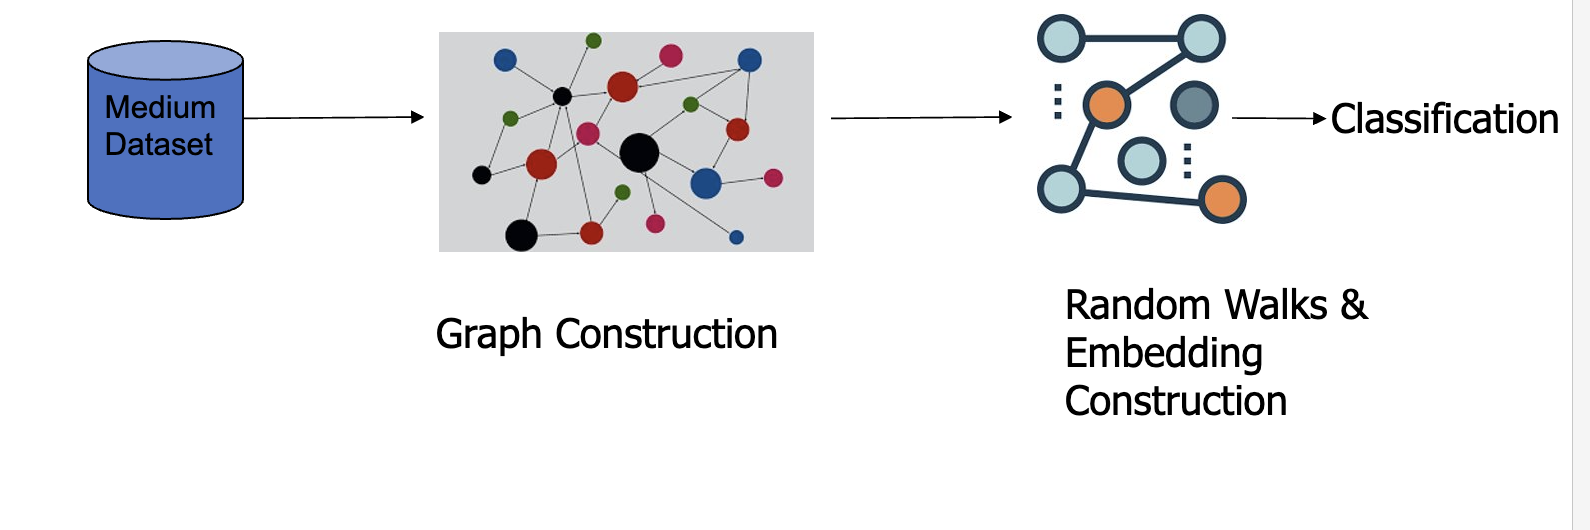

# Form graph

Our goal is to construct a graph from  given data by connecting nodes that atleast share one common subscription list. The networkx part has already been written for you.

Your task here is to write the module to construct the edges and find isolated nodes and also analyze the resulting graph by reporting number of edges, number of nodes, number of isolated nodes. 



In [59]:
from typing import List,Dict
from itertools import combinations

def get_edges(data: pd.DataFrame, nodes) -> List:
    """ Given the dataframe with articles and lists return the set of edges
        Args:
        data (pd.DataFrame): The medium dataset
        nodes: dict (nodeid: article title)
    Returns:
            edges (List[tuple]): List of edges"""
    edges = []    
    ## START
    data['index'] = data.index
    grouped_titles = data.groupby('list')['index'].apply(list)
    title_tuples = []
    for titles in grouped_titles:
        title_combinations = combinations(titles, 2)
        title_tuples.extend(title_combinations)

    # Remove duplicates
    edges = list(set(map(tuple, map(sorted, title_tuples))))
    ##END
    return edges

In [60]:
def get_nodes(data: pd.DataFrame) -> Dict:
    """ Given the dataframe with articles and lists return the set of nodes
        Args:
        data (pd.DataFrame): The medium dataset
    Returns:
        nodes: dict (nodeid: article title)"""
    nodes = {}
    for index, row in data.iterrows():
        if index not in nodes:
            nodes[index] = row["title"]
    return nodes

In [61]:
import networkx as nx
def form_graph(data: pd.DataFrame) -> nx.Graph:
    """Forms graph from medium article dataset.

    Args:
        data (pd.DataFrame): The medium dataset

    Returns:
        G (nx.Graph): The graph.

       """
    texts = [x[0]+" " + x[1] for x in zip(data.title,data.subtitle)]
    nodes = get_nodes(data)
    edges = get_edges(data, nodes)
    graph = nx.Graph()
    graph.add_nodes_from(list(nodes.keys()))
    graph.add_edges_from(edges)
    return graph


In [62]:
graph = form_graph(final_data)

Number of nodes:

In [63]:
len(graph.nodes())

27718

Number of edges:

In [64]:
len(graph.edges())

473778

# Node2Vec

Here the task is to perform random walks on the graph formed in the previous step and compute embeddings for the nodes using the random walk results.

You can use gensim to compute embeddings, however for random walks you are expected to implement without relying on networkx. Your weblab assignment would aid you in the same. For gensim you are expected to use Word2Vec. However you  can explore on best ways to configure the hyperparams for your word2vec instance for better donwstream classification task.

In [65]:
# Find isolated nodes with no neighbors before random walks
isolated = [node for node, degree in graph.degree() if degree == 0]
len(isolated)

6292

There are therefore 6292 isolated nodes.

The following modified version of random walks ignores isolated nodes and does not try to start a random walk in one of them, as it would get stuck and would not give us any useful information.

In [66]:
def random_walks(graph: nx.Graph, num_walks: int, walk_length: int, isolated: list) -> np.ndarray:
    """Perform random walks on an unweighted graph.

    Args:
        graph (nx.Graph): The graph.
        num_walks (int): The number of random walks for each node.
        walk_length (int): The number of nodes in a random walk.
        isolated (List[int]): list of isolated nodeids


    Returns:
        np.ndarray: The random walks, shape (num_walks * n_nodes, walk_length)
    """
    result = []

    # START ANSWER
    nodes = list(graph.nodes())

    for _ in range(num_walks):
        for node in nodes:
            if node in isolated:
                continue
            walk = [node]
            for _ in range(walk_length - 1):
                neighbors = list(graph.neighbors(node))
                next_node = np.random.choice(neighbors)
                walk.append(next_node)
                node = next_node

            result.append(walk)
    # END ANSWER
    return np.array(result)

In [67]:
walks = random_walks(graph, 8, 15,isolated)

Convert all values in walks to strings to speed up computations.

In [68]:
walks = [list(map(str, walk)) for walk in walks]

Add workers variable to speed up training, make sure to change it according to the capabilities of your system.

In [69]:
from gensim.models import Word2Vec
def fit_node2vec(walks: np.ndarray, vector_size: int, window: int, epochs: int, workers: int) -> Word2Vec:
    """Train a Node2Vec model on random walks. Uses the GenSim Word2Vec implementation.

    Args:
        walks (np.ndarray): The random walks.
        vector_size (int): Node representation size.
        window (int): Window width.
        epochs (int): Number of epochs.
    Returns:
        Word2Vec: The trained model."""

    model = Word2Vec(sentences = walks, vector_size = vector_size, window = window, epochs = epochs, workers = workers)
    return model

In [70]:
model = fit_node2vec(walks, 128, 5, 10, 6)

In [71]:
def get_nodeids(data: pd.DataFrame):
    """Get nodeids from graph

    Args:
        data (pd.DataFrame): medium articles dataset

    Returns:
        nodes (dict): nodeids with mapped article titles
    """
    nodes = {}
    for index, row in data.iterrows():
        if row["index"] not in nodes:
            nodes[row["index"]] = row["title"]
    return nodes

In [72]:
# Get train and test nodes from the graph

train_nodes = get_nodeids(train)
test_nodes = get_nodeids(test)
train_nodes = list(train_nodes.keys())
test_nodes = list(test_nodes.keys())

In [73]:
len(test_nodes)

3950

In [74]:
# Get node2vec embeddings (nodeid to embeddings mapping)

embeddings = {word: model.wv[word] for word in model.wv.index_to_key}

# Word2vec + Node2vec

In [95]:
"""Compute train and test embeddings.
Concatenate the word2vec embeddings of article titles
with the node2vec embeddings suing dictionary from previous step.
Dimension 1 of your embeddings should be 256.
 Consider isolated nodes and handle them when computing embeddings"""

X_train_n2v_w2v = []
for idx in range(len(X_word2vec)):
    X_train_n2v_w2v.append(np.concatenate((X_word2vec[int(idx)], (np.zeros(128) if idx in isolated else embeddings[str(idx)]))))
X_train_n2v_w2v = np.array(X_train_n2v_w2v)

X_test_n2v_w2v = []
for idx in range(len(X_word2vec_test)):
    X_test_n2v_w2v.append(np.concatenate((X_word2vec_test[int(idx)], (np.zeros(128) if idx + len(X_word2vec) in isolated else embeddings[str(idx + len(X_word2vec))]))))
X_test_n2v_w2v = np.array(X_test_n2v_w2v)

In [96]:
X_train_n2v_w2v.shape

(22382, 256)

In [97]:
X_test_n2v_w2v.shape

(3950, 256)

In [98]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC,SVC

svc = SVC()
svc.fit(X_train_n2v_w2v,Y)

SVC()

In [99]:
Y.shape

(22382,)

In [100]:
X_test_n2v_w2v.shape

(3950, 256)

In [101]:
predictions = svc.predict(X_test_n2v_w2v)

In [102]:
predictions

array([0, 0, 1, ..., 0, 0, 0])

In [103]:
from sklearn import metrics
print(metrics.f1_score(Y_test, predictions,average="macro"))


0.5367118674812952


In [104]:
print(metrics.classification_report(Y_test, predictions))


              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1899
           1       0.80      0.82      0.81      2022
           2       0.00      0.00      0.00        29

    accuracy                           0.80      3950
   macro avg       0.53      0.54      0.54      3950
weighted avg       0.80      0.80      0.80      3950



C:\Users\ignac\Documents\Ignacio\Delft\TUDelft\TUDelftFiles\Y2\Q2\DataMining\graphs\venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ignac\Documents\Ignacio\Delft\TUDelft\TUDelftFiles\Y2\Q2\DataMining\graphs\venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ignac\Documents\Ignacio\Delft\TUDelft\TUDelftFiles\Y2\Q2\DataMining\graphs\venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with

# Only node2vec features

In [105]:
X_train_n2v =  np.array([embeddings[str(x)] if x not in isolated else np.zeros((128)) for idx, x in enumerate(train_nodes)  ], dtype=np.float32)

X_test_n2v =np.array([embeddings[str(x)] if x not in isolated else np.zeros((128)) for idx, x in enumerate(test_nodes)  ], dtype=np.float32)
 

In [106]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC,SVC

svc = SVC()
svc.fit(X_train_n2v,Y)

SVC()

In [107]:
predictions = svc.predict(X_test_n2v)

In [108]:
from sklearn import metrics
print(metrics.f1_score(Y_test, predictions,average="macro"))

0.6958961847581754


In [110]:
print(metrics.classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.71      0.86      0.78      1899
           1       0.84      0.68      0.75      2022
           2       0.86      0.41      0.56        29

    accuracy                           0.76      3950
   macro avg       0.80      0.65      0.70      3950
weighted avg       0.78      0.76      0.76      3950

              precision    recall  f1-score   support

           0       0.71      0.86      0.78      1899
           1       0.84      0.68      0.75      2022
           2       0.86      0.41      0.56        29

    accuracy                           0.76      3950
   macro avg       0.80      0.65      0.70      3950
weighted avg       0.78      0.76      0.76      3950



 Compare performance of word2vec only, node2vec embeddings only (above) and word2vec+node2vec settings.
  Report your intuition below in text as to why one works better than other and to what extent network structure helps compared to only using word2vec embeddings of titles and subtitles (first result).

 You can also plot the tsne plot of embeddings to gain more intuition

# tSNE

Take into account that it takes a while for matplotlib to plot the results.

In [123]:
from mpl_toolkits.mplot3d import Axes3D

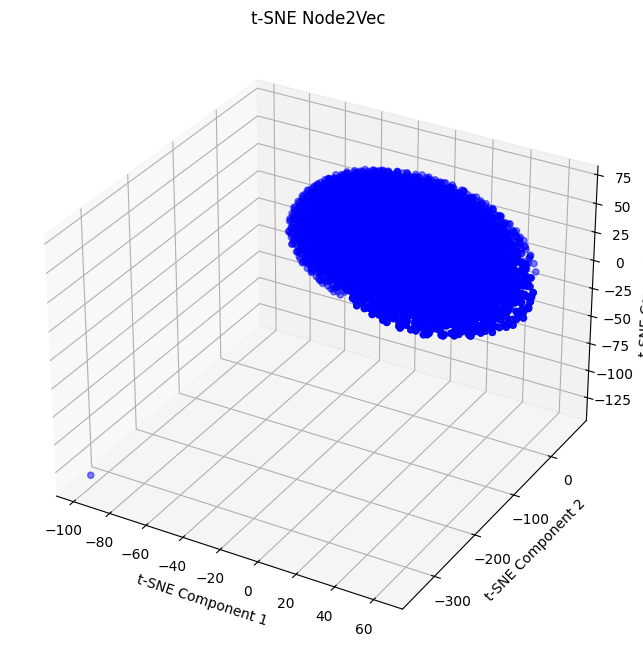

In [124]:
tsne_node2vec = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(X_train_n2v)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_node2vec[:, 0], tsne_node2vec[:, 1], tsne_node2vec[:, 2], marker='o', color='b', alpha=0.5)

ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('t-SNE Node2Vec')

plt.show()

In [ ]:
tsne_node2vec_word2vec = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(X_train_n2v_w2v)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_node2vec_word2vec[:, 0], tsne_node2vec_word2vec[:, 1], tsne_node2vec_word2vec[:, 2], marker='o', color='b', alpha=0.5)

ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('t-SNE Node2Vec and Word2Vec')

plt.show()